In [1]:
from app import db
from db import DeadManPackage, Connectivity
import pandas as pd
from  analytics.connection import connection, _connection_for_device, connection_timeseries, connection_data_per_day
from analytics.sensors import get_sensor_data
from datetime import timedelta, date
from utils.date import start_of_day, end_of_day
import numpy as np
from utils.interval import find_intervals
from analytics.mouse import get_mouse_data_raw, get_mouse_data_aggregated
from clustering.clustering import get_input_data, plot_distributions, input_data_clustering, cluster_palette
import seaborn as sns
from sklearn.model_selection import train_test_split
from matplotlib.figure import Figure

In [2]:
device = "PTL_RD_AT_003"
d1 = date(2020, 2, 1)
d2 = date.today() - timedelta(days=1)

In [3]:
cluster_data = input_data_clustering(device, d1)

In [4]:
cluster_data

,cluster
timestamp,
2020-02-10 12:13:00,4
2020-02-10 12:14:00,4
2020-02-10 12:15:00,4
2020-02-10 12:16:00,4
2020-02-10 12:17:00,4
...,...
2020-03-26 11:59:00,0
2020-03-26 12:00:00,0
2020-03-26 12:01:00,0


In [5]:
cluster_data['date'] = cluster_data.index.date
cluster_data['time'] = cluster_data.index.time

In [151]:
cluster_data

,cluster,date,time
timestamp,,,
2020-02-10 12:13:00,4,2020-02-10,12:13:00
2020-02-10 12:14:00,4,2020-02-10,12:14:00
2020-02-10 12:15:00,4,2020-02-10,12:15:00
2020-02-10 12:16:00,4,2020-02-10,12:16:00
2020-02-10 12:17:00,4,2020-02-10,12:17:00
...,...,...,...
2020-03-26 11:59:00,0,2020-03-26,11:59:00
2020-03-26 12:00:00,0,2020-03-26,12:00:00
2020-03-26 12:01:00,0,2020-03-26,12:01:00


In [152]:
cluster_data.loc[:, "c_0"] = (cluster_data.cluster == 0).astype(int)
cluster_data.loc[:, "c_1"] = (cluster_data.cluster == 1).astype(int)
cluster_data.loc[:, "c_2"] = (cluster_data.cluster == 2).astype(int)
cluster_data.loc[:, "c_3"] = (cluster_data.cluster == 3).astype(int)
cluster_data.loc[:, "c_4"] = (cluster_data.cluster == 4).astype(int)

In [153]:
daily_histogram = cluster_data.drop(columns=['cluster']).groupby('date').sum()

In [155]:
dh = daily_histogram.copy()
dh['total'] = dh.sum(axis=1)
dh.c_0 = dh.c_0 / dh.total
dh.c_1 = dh.c_1 / dh.total
dh.c_2 = dh.c_2 / dh.total
dh.c_3 = dh.c_3 / dh.total
dh.c_4 = dh.c_4 / dh.total
dh

,c_0,c_1,c_2,c_3,c_4,total
date,,,,,,
2020-02-10,0.000000,0.000000,0.000000,0.000000,1.000000,707
2020-02-11,0.000000,0.000000,0.000000,0.000000,1.000000,1440
2020-02-12,0.000000,0.000000,0.000000,0.000000,1.000000,1440
2020-02-13,0.000000,0.000000,0.000000,0.000000,1.000000,1440
2020-02-14,0.000000,0.000000,0.000000,0.000000,1.000000,1440
2020-02-15,0.000000,0.000000,0.000000,0.000000,1.000000,1440
2020-02-16,0.000000,0.000000,0.000000,0.000000,1.000000,1440
2020-02-17,0.000000,0.000000,0.000000,0.000000,1.000000,1440
2020-02-18,0.321528,0.001389,0.011806,0.012500,0.652778,1440


In [139]:
pdata = dh.transpose()
pdata = pdata.rename(columns={date: str(date) for date in pdata.columns})
pdata['colors'] = [color_to_hex(c) for c in palette]
pdata

date,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,2020-02-16,2020-02-17,2020-02-18,2020-02-19,...,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,2020-03-24,2020-03-25,2020-03-26,colors
c_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.321528,0.993750,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.372917,0.955801,#023eff
c_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.322917,0.993750,...,0.001389,0.305556,0.809028,1.0,1.0,0.343750,0.026389,0.375694,0.955801,#ff7c00
c_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.334722,0.997917,...,0.066667,0.422917,0.809722,1.0,1.0,0.395833,0.045139,0.445833,0.995856,#1ac938
c_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.347222,0.997917,...,0.565972,0.852778,0.809722,1.0,1.0,0.570833,0.268056,0.564583,0.995856,#e8000b
c_4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000,#8b2be2


In [141]:
len(pdata)

5

In [101]:
palette

[(0.00784313725490196, 0.24313725490196078, 1.0),
 (1.0, 0.48627450980392156, 0.0),
 (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
 (0.9098039215686274, 0.0, 0.043137254901960784),
 (0.5450980392156862, 0.16862745098039217, 0.8862745098039215)]

In [137]:
def color_to_hex(c):
    r, g, b = c
    r = int(r * 255)
    g = int(g * 255)
    b = int(b * 255)
    return f"#{r:02x}{g:02x}{b:02x}"

In [138]:
[color_to_hex(c) for c in palette]

['#023eff', '#ff7c00', '#1ac938', '#e8000b', '#8b2be2']

In [78]:
import numpy as np
import matplotlib.pyplot as plt

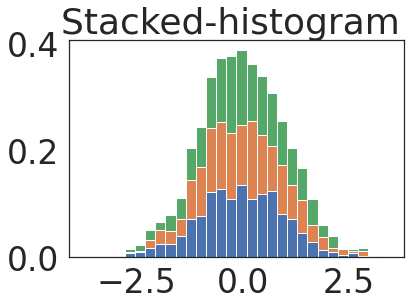

In [81]:
n_bins=30
x = np.random.randn(1000, 3)
colors = ['blue', 'orange', 'green']
plt.hist(x, n_bins, density=1, histtype='bar', stacked=True, label=colors)
plt.title('Stacked-histogram ')
plt.show()

In [82]:
x

array([[ 0.25275135,  1.23060615, -0.6516847 ],
       [ 1.28972067,  0.0113989 , -0.56451684],
       [-0.1868493 , -0.47263985, -0.0134089 ],
       ...,
       [ 0.77451153, -0.02202259,  0.53905613],
       [-0.35049844,  0.35112076, -1.27142648],
       [-1.50482646, -1.28915597,  1.30622996]])

In [15]:
from datetime import datetime, date

In [16]:
cluster_data[cluster_data.date == date(2020, 2, 10)]

,cluster,date,time
timestamp,,,
2020-02-10 12:13:00,4,2020-02-10,12:13:00
2020-02-10 12:14:00,4,2020-02-10,12:14:00
2020-02-10 12:15:00,4,2020-02-10,12:15:00
2020-02-10 12:16:00,4,2020-02-10,12:16:00
2020-02-10 12:17:00,4,2020-02-10,12:17:00
...,...,...,...
2020-02-10 23:55:00,4,2020-02-10,23:55:00
2020-02-10 23:56:00,4,2020-02-10,23:56:00
2020-02-10 23:57:00,4,2020-02-10,23:57:00


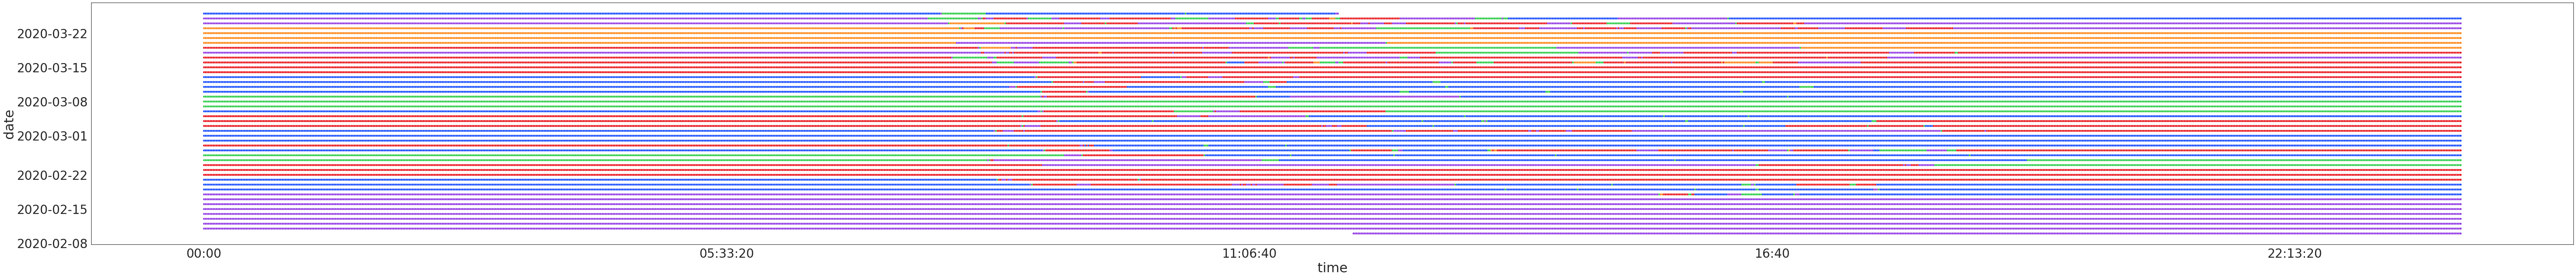

In [44]:

sns.set(font_scale = 3, style='white')
cp = sns.color_palette('bright')
num_clusters = len(cluster_data.cluster.unique())
palette = cp[0:num_clusters]

fig = Figure(figsize=(120, 12))
ax = fig.add_subplot(1, 1, 1)
sns.scatterplot(data=cluster_data, y="date", x="time", hue="cluster", markers=num_clusters * ['s'], palette=palette, legend=False, ax=ax)

fig

In [50]:
num_clusters

5

In [ ]:
# PCA Scatter plot

In [3]:
pca_data = input_data_clustering(device, d1, return_pca=True)

In [4]:
pca_data

,cluster,d_0,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,...,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24
0,2,-5.806680,-3.095764,7.406087,0.078475,-4.606508,-0.311810,-0.538106,0.498037,-2.180225,...,-0.267745,0.367135,-1.106642,-0.550333,-0.179758,-0.562142,-0.118208,-0.151844,0.869216,-0.535665
1,2,-5.847345,-1.897447,6.835620,-2.095875,1.179805,4.399243,0.032524,2.602383,1.820342,...,0.198058,1.066524,1.404370,0.601861,0.006542,-0.595392,0.378410,0.785981,-0.290836,1.304644
2,2,-7.086684,-1.369314,6.520057,-1.622880,-0.055254,2.034311,-1.780649,-0.527971,2.870816,...,-1.403959,1.564217,0.572855,0.102022,-0.921280,-1.512367,-0.339281,0.141801,-0.857076,0.327680
3,2,-7.303388,-1.168010,6.554130,-2.170642,0.238759,2.106221,-2.473899,-0.729626,3.654481,...,-1.345490,1.014201,0.513519,0.002272,-0.967395,-1.711781,-0.486017,-0.081489,-0.606664,0.132874
4,2,-7.140564,-1.080283,6.412727,-2.274702,0.308601,1.823923,-2.327157,-1.010631,3.758465,...,-1.402835,0.879336,0.273303,-0.279218,-0.745750,-1.262725,-0.221545,0.010169,-0.416539,0.280289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64786,1,-1.877492,22.491438,4.992161,1.387844,4.088613,4.114373,2.153777,2.342731,3.203114,...,5.678901,-1.012539,1.804998,-0.410630,1.001753,-0.165623,-0.973649,1.053985,-0.690387,7.968196
64787,1,-1.877492,22.491438,4.992161,1.387844,4.088613,4.114373,2.153777,2.342731,3.203114,...,5.678901,-1.012539,1.804998,-0.410630,1.001753,-0.165623,-0.973649,1.053985,-0.690387,7.968196
64788,1,-1.877492,22.491438,4.992161,1.387844,4.088613,4.114373,2.153777,2.342731,3.203114,...,5.678901,-1.012539,1.804998,-0.410630,1.001753,-0.165623,-0.973649,1.053985,-0.690387,7.968196
64789,2,-5.784470,-3.606670,7.361119,0.600722,-4.437496,-0.645266,-0.948424,0.370375,-1.609157,...,-0.287266,0.475967,-1.546501,-0.174038,0.298188,-0.156516,-0.209241,0.405002,0.874639,-0.032861


In [9]:
_, df = train_test_split(pca_data.iloc[:, :5], test_size=5000)

In [58]:
df = pca_data.iloc[:, :5]

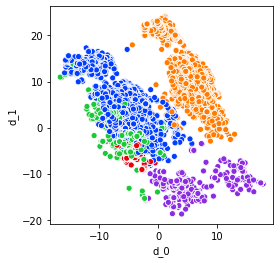

In [76]:
fig = Figure(figsize=(4, 4))
ax = fig.add_subplot(1,1,1)
sns.scatterplot(x="d_0", y="d_1", data=df, hue='cluster', palette=cp[0:len(df.cluster.unique())], legend=False, ax=ax)
#ax.set_ylabel('')    
#ax.set_xlabel('')
#ax.xaxis.set_visible(False)
#ax.yaxis.set_visible(False)
fig

In [75]:
cp[0:len(df.cluster.unique())]

[(0.00784313725490196, 0.24313725490196078, 1.0),
 (1.0, 0.48627450980392156, 0.0),
 (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
 (0.9098039215686274, 0.0, 0.043137254901960784),
 (0.5450980392156862, 0.16862745098039217, 0.8862745098039215)]

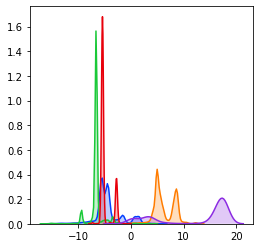

In [78]:
fig = Figure(figsize=(4, 4))
ax = fig.add_subplot(1,1,1)
for cluster in sorted(df.cluster.unique()):
    sns.kdeplot(df.d_0[df.cluster == cluster], shade=True, color=cp[cluster], legend=False, ax=ax)
fig

In [41]:
cp = sns.color_palette('bright')

In [51]:
sns.scatterplot?

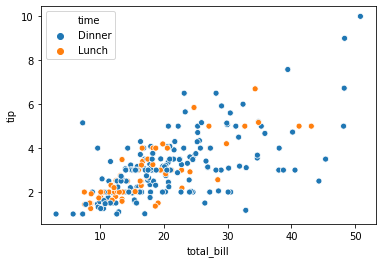

In [7]:
tips = sns.load_dataset("tips")

ax = sns.scatterplot(x="total_bill", y="tip", hue="time", data=tips)

In [8]:
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


In [19]:
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)

In [27]:
ax = sns.scatterplot(x="1", y="2", data=pca_data, hue='cluster', palette=sns.color_palette('bright'))
ax.set_aspect(1, )

ValueError: Could not interpret input '1'

In [26]:
sns.color_palette('bright')

[(0.00784313725490196, 0.24313725490196078, 1.0),
 (1.0, 0.48627450980392156, 0.0),
 (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
 (0.9098039215686274, 0.0, 0.043137254901960784),
 (0.5450980392156862, 0.16862745098039217, 0.8862745098039215),
 (0.6235294117647059, 0.2823529411764706, 0.0),
 (0.9450980392156862, 0.2980392156862745, 0.7568627450980392),
 (0.6392156862745098, 0.6392156862745098, 0.6392156862745098),
 (1.0, 0.7686274509803922, 0.0),
 (0.0, 0.8431372549019608, 1.0)]

In [73]:
pca_data.columns[0:5]

Index(['d_0', 'd_1', 'd_2', 'd_3', 'd_4'], dtype='object')

In [74]:
df = pca_data.iloc[:, 0:5]

In [76]:
df.loc[:, 'cluster'] = pca_data['cluster']

In [77]:
df

,d_0,d_1,d_2,d_3,d_4,cluster
0,-5.806680,-3.095764,7.406087,0.078475,-4.606508,4
1,-5.847345,-1.897447,6.835620,-2.095875,1.179805,4
2,-7.086684,-1.369314,6.520057,-1.622880,-0.055254,4
3,-7.303388,-1.168010,6.554130,-2.170642,0.238759,4
4,-7.140564,-1.080283,6.412727,-2.274702,0.308601,4
...,...,...,...,...,...,...
64786,-1.877492,22.491438,4.992161,1.387844,4.088613,1
64787,-1.877492,22.491438,4.992161,1.387844,4.088613,1
64788,-1.877492,22.491438,4.992161,1.387844,4.088613,1
64789,-5.784470,-3.606670,7.361119,0.600722,-4.437496,4


In [8]:
from sklearn.model_selection import train_test_split
_, b = train_test_split(df, test_size=5000)

In [79]:
df

,cluster,d_0,d_1,d_2,d_3
0,2,-5.806680,-3.095764,7.406087,0.078475
1,2,-5.847345,-1.897447,6.835620,-2.095875
2,2,-7.086684,-1.369314,6.520057,-1.622880
3,2,-7.303388,-1.168010,6.554130,-2.170642
4,2,-7.140564,-1.080283,6.412727,-2.274702
...,...,...,...,...,...
64786,1,-1.877492,22.491438,4.992161,1.387844
64787,1,-1.877492,22.491438,4.992161,1.387844
64788,1,-1.877492,22.491438,4.992161,1.387844
64789,2,-5.784470,-3.606670,7.361119,0.600722


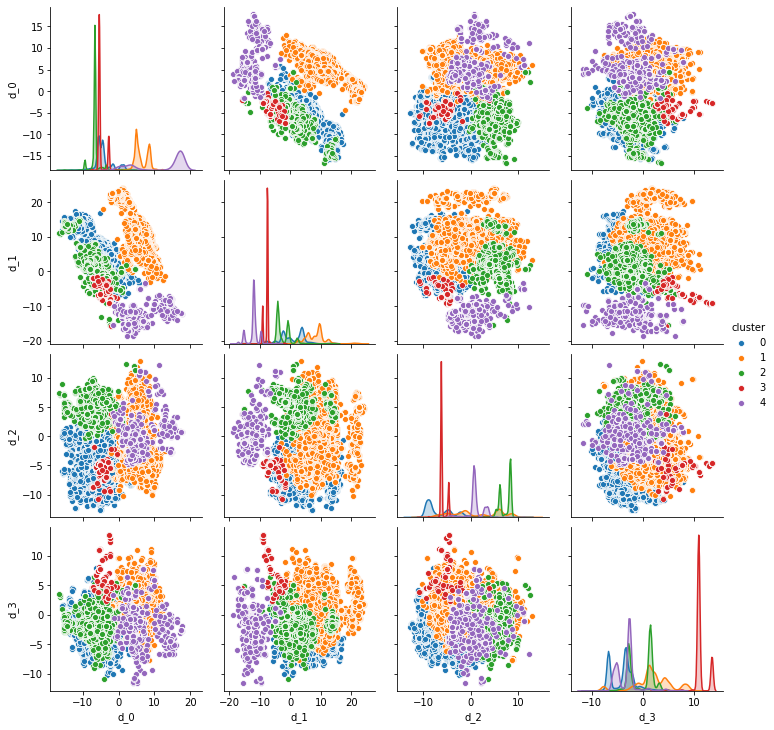

In [80]:
grid = sns.pairplot(df, hue="cluster", diag_kind="kde")

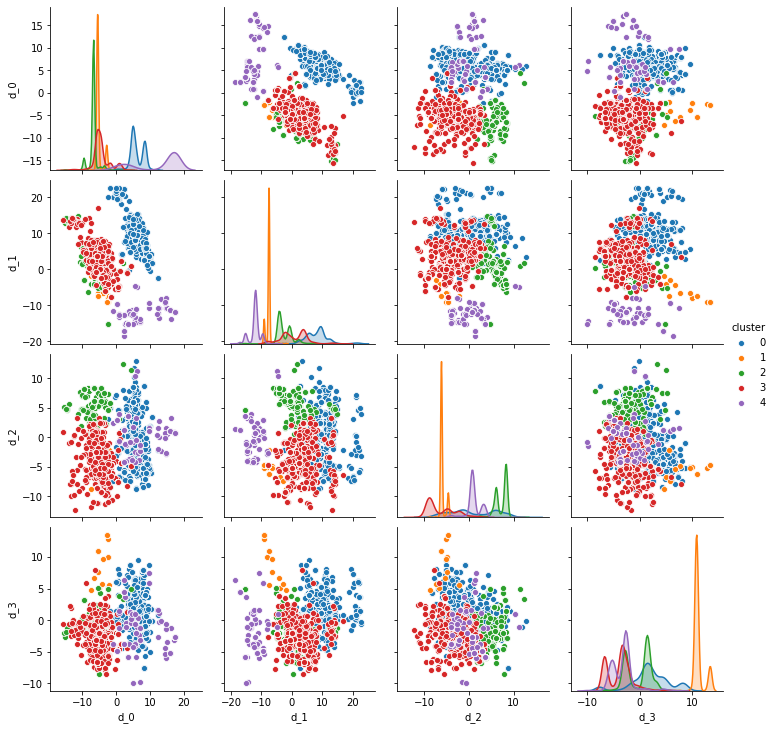

In [47]:
grid.fig

In [48]:
fig = grid.fig

In [52]:
fig.clf?

In [28]:
fig = Figure()
for row in range(4):
    for column in range(4):
        grid[row, column]

TypeError: 'PairGrid' object is not subscriptable

In [36]:
grid

In [42]:
f = grid.fig

In [43]:
f

matplotlib.figure.Figure

In [38]:
isinstance(grid, sns.axisgrid.PairGrid)

True

In [ ]:
def sample_of_n(data, n):
    datapoints = data.shape[0]
    train_test_split(data, test_size)

In [13]:
pca

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,cluster
0,-5.806680,-3.095764,7.406087,0.078475,-4.606508,-0.311810,-0.538106,0.498037,-2.180225,0.189810,...,0.367135,-1.106642,-0.550333,-0.179758,-0.562142,-0.118208,-0.151844,0.869216,-0.535665,1
1,-5.847345,-1.897447,6.835620,-2.095875,1.179805,4.399243,0.032524,2.602383,1.820342,1.830852,...,1.066524,1.404370,0.601861,0.006542,-0.595392,0.378410,0.785981,-0.290836,1.304644,1
2,-7.086684,-1.369314,6.520057,-1.622880,-0.055254,2.034311,-1.780649,-0.527971,2.870816,2.477163,...,1.564217,0.572855,0.102022,-0.921280,-1.512367,-0.339281,0.141801,-0.857076,0.327680,1
3,-7.303388,-1.168010,6.554130,-2.170642,0.238759,2.106221,-2.473899,-0.729626,3.654481,2.377824,...,1.014201,0.513519,0.002272,-0.967395,-1.711781,-0.486017,-0.081489,-0.606664,0.132874,1
4,-7.140564,-1.080283,6.412727,-2.274702,0.308601,1.823923,-2.327157,-1.010631,3.758465,2.354324,...,0.879336,0.273303,-0.279218,-0.745750,-1.262725,-0.221545,0.010169,-0.416539,0.280289,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64786,-1.877492,22.491438,4.992161,1.387844,4.088613,4.114373,2.153777,2.342731,3.203114,-1.182908,...,-1.012539,1.804998,-0.410630,1.001753,-0.165623,-0.973649,1.053985,-0.690387,7.968196,0
64787,-1.877492,22.491438,4.992161,1.387844,4.088613,4.114373,2.153777,2.342731,3.203114,-1.182908,...,-1.012539,1.804998,-0.410630,1.001753,-0.165623,-0.973649,1.053985,-0.690387,7.968196,0
64788,-1.877492,22.491438,4.992161,1.387844,4.088613,4.114373,2.153777,2.342731,3.203114,-1.182908,...,-1.012539,1.804998,-0.410630,1.001753,-0.165623,-0.973649,1.053985,-0.690387,7.968196,0
64789,-5.784470,-3.606670,7.361119,0.600722,-4.437496,-0.645266,-0.948424,0.370375,-1.609157,0.150724,...,0.475967,-1.546501,-0.174038,0.298188,-0.156516,-0.209241,0.405002,0.874639,-0.032861,1


In [5]:
c_hist = cluster_histogram(clustering)

In [6]:
c_hist

count
date       cluster       
2020-02-10 0          707
           1            0
           2            0
           3            0
           4            0
...                   ...
2020-03-26 0            3
           1            0
           2           29
           3          692
           4            0

[230 rows x 1 columns]

In [1]:
from app import db
from db import Errors

In [13]:
data, pageination = Errors.restarts('PTL_RD_AT_001', limit=10, page=3)

In [14]:
data

,device,timestamp,version_timestamp,branch,commit,ip,crash
0,PTL_RD_AT_001,2020-04-21 18:15:48.422204,2020-04-15 06:32:44,master,f5ec28bef2073d137e3d2fb1b6c909e99bbb3617,10.200.1.85,False
1,PTL_RD_AT_001,2020-04-21 17:50:42.983941,2020-04-15 06:32:44,master,f5ec28bef2073d137e3d2fb1b6c909e99bbb3617,10.200.1.85,False
2,PTL_RD_AT_001,2020-04-21 17:43:44.883506,2020-04-15 06:32:44,master,f5ec28bef2073d137e3d2fb1b6c909e99bbb3617,10.200.1.85,False
3,PTL_RD_AT_001,2020-04-15 06:36:02.111535,2020-04-15 06:32:44,master,f5ec28bef2073d137e3d2fb1b6c909e99bbb3617,10.200.1.85,False
4,PTL_RD_AT_001,2020-04-09 10:50:01.744401,2020-04-09 10:45:05,master,b065a099602b9bfbc48874ead2b036f8e5994d6b,10.200.1.85,False
5,PTL_RD_AT_001,2020-04-09 09:08:01.659477,2020-04-09 09:02:55,master,5f1622c040d28502cd0de84eeb7401c666ac3dfb,10.200.1.85,False
6,PTL_RD_AT_001,2020-04-09 08:50:02.016042,2020-04-09 08:45:28,master,760fbf54e4b6e3d4b6492af47bb53bbe403b7aa5,10.200.1.85,False
7,PTL_RD_AT_001,2020-04-08 22:43:02.482510,2020-04-08 22:38:18,master,2c822440a9afcbfcfaaf0d1489bd565865aa1b5a,10.200.1.85,False
8,PTL_RD_AT_001,2020-04-08 22:36:01.653622,2020-04-08 22:29:55,master,4c9b780a0ee0df0551dcbd4282204e17ee0e1926,10.200.1.85,False
9,PTL_RD_AT_001,2020-04-08 22:22:01.487254,2020-04-08 22:19:32,master,8ceb9008ca97c384929418d4e00e5589f5f27f97,10.200.1.85,False


In [8]:
pageination.next().page

2

In [43]:
data.reset_index()

,device,level_1,timestamp,version_timestamp,branch,commit,ip,crash
0,PTL_RD_AT_003,0,2020-04-22 17:51:13.549465,2020-03-19 15:02:53,release,1be1e766d4cf42c27a074e17fa10227fd12b9af1,10.200.1.22,True
1,PTL_RD_AT_003,1,2020-04-27 11:56:40.291520,2020-03-19 15:02:53,release,1be1e766d4cf42c27a074e17fa10227fd12b9af1,10.200.1.22,True


In [11]:
from matplotlib.figure import Figure
import seaborn as sns
import math

sns.set(style="dark")
columns = 5
rows = math.ceil(len(dates)/columns)
fig = Figure(figsize=(columns * 3, rows * 3), constrained_layout=True)
for i, d in enumerate(dates[:5]):
    ax = fig.add_subplot(rows, columns, i+1)
    sns.distplot(c_hist.loc[d]['count'], ax=ax, kde=False)

fig

KeyboardInterrupt: 

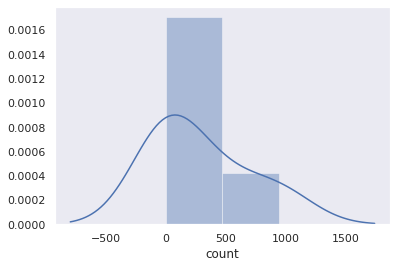

In [27]:
sns.distplot(c_hist.loc[dates[8]]['count'], kde=True)

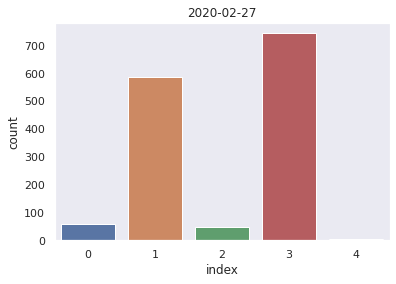

In [63]:
i = 17
fig = Figure()
ax = fig.add_subplot(111)
dd = new_df.loc[dates[i]].reset_index()
sns.barplot(x="index", y="count", data=dd, ax=ax)
ax.set_title(dates[i])
fig

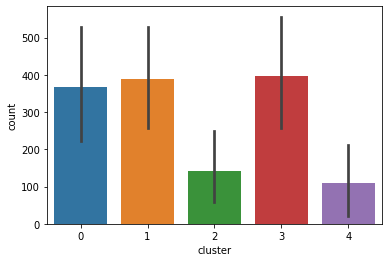

In [9]:
sns.barplot(x="cluster", y="count", data=c_hist.reset_index())

In [18]:
c_hist.reset_index()

,date,cluster,count
0,2020-02-10,0,707
1,2020-02-10,1,0
2,2020-02-10,2,0
3,2020-02-10,3,0
4,2020-02-10,4,0
...,...,...,...
225,2020-03-26,0,3
226,2020-03-26,1,0
227,2020-03-26,2,29
228,2020-03-26,3,692


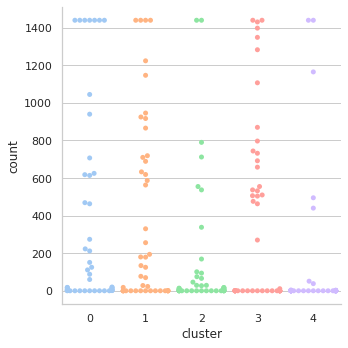

In [35]:
sns.catplot(y="count", x="cluster", kind="swarm", palette="pastel", edgecolor=".6", data=c_hist.reset_index())

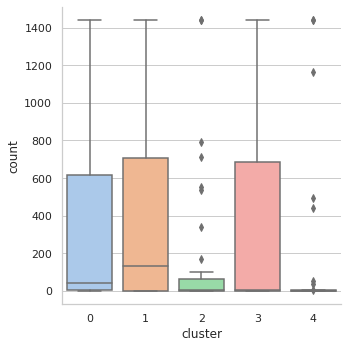

In [37]:
sns.catplot(y="count", x="cluster", kind="box", palette="pastel", data=c_hist.reset_index())

In [4]:
data = data.drop(columns=['gesture_duration'])

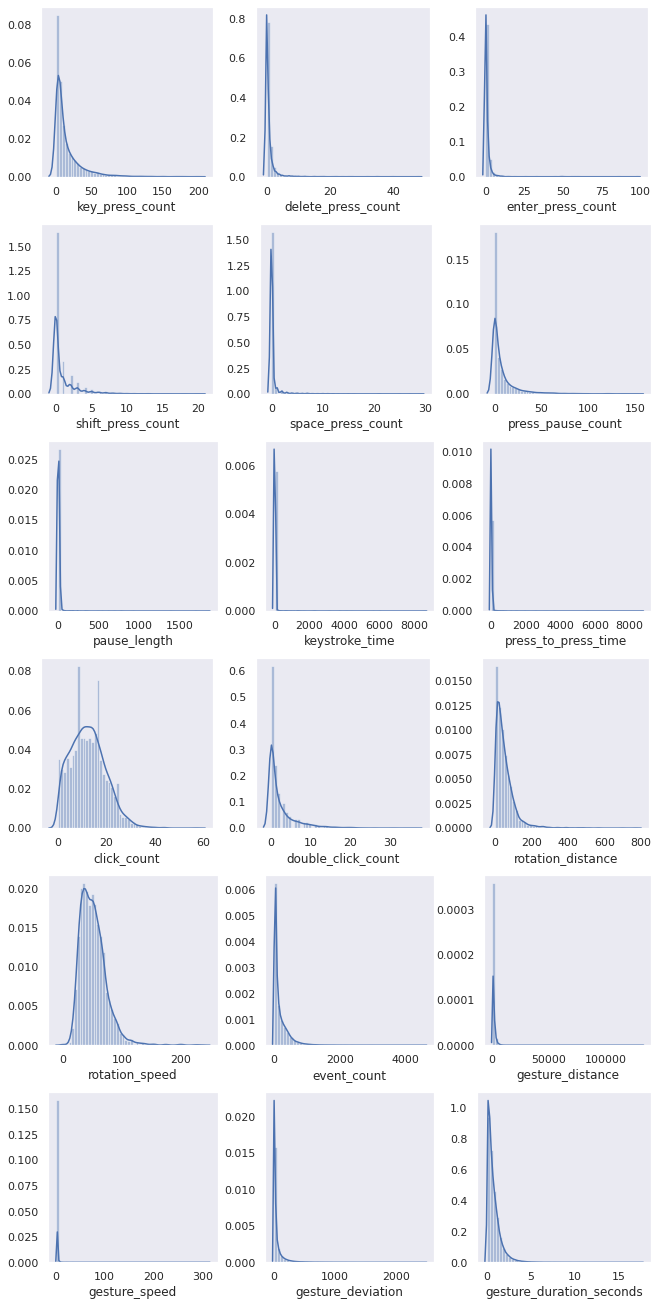

In [8]:
plot_distributions(data)

In [79]:
import numpy as np
from sklearn.preprocessing import PowerTransformer, StandardScaler, QuantileTransformer

In [6]:
pt = PowerTransformer()

In [7]:
pt.fit(data)

PowerTransformer(copy=True, method='yeo-johnson', standardize=True)

In [9]:
pt.get_params()

{'copy': True, 'method': 'yeo-johnson', 'standardize': True}

In [10]:
pt.lambdas_

array([-0.14385649, -3.24170747, -2.13161064, -1.77959893, -9.7818344 ,
       -0.24339323, -0.32048832, -3.00174757, -0.25148309,  0.58661449,
       -0.59265031,  0.14116734,  0.21483361, -0.08257871, -0.01187372,
       -1.73372117, -0.14480613, -1.14398844])

In [11]:
data_normalized = pt.transform(data)

In [13]:
data_normalized = pd.DataFrame(data_normalized, columns=data.columns)

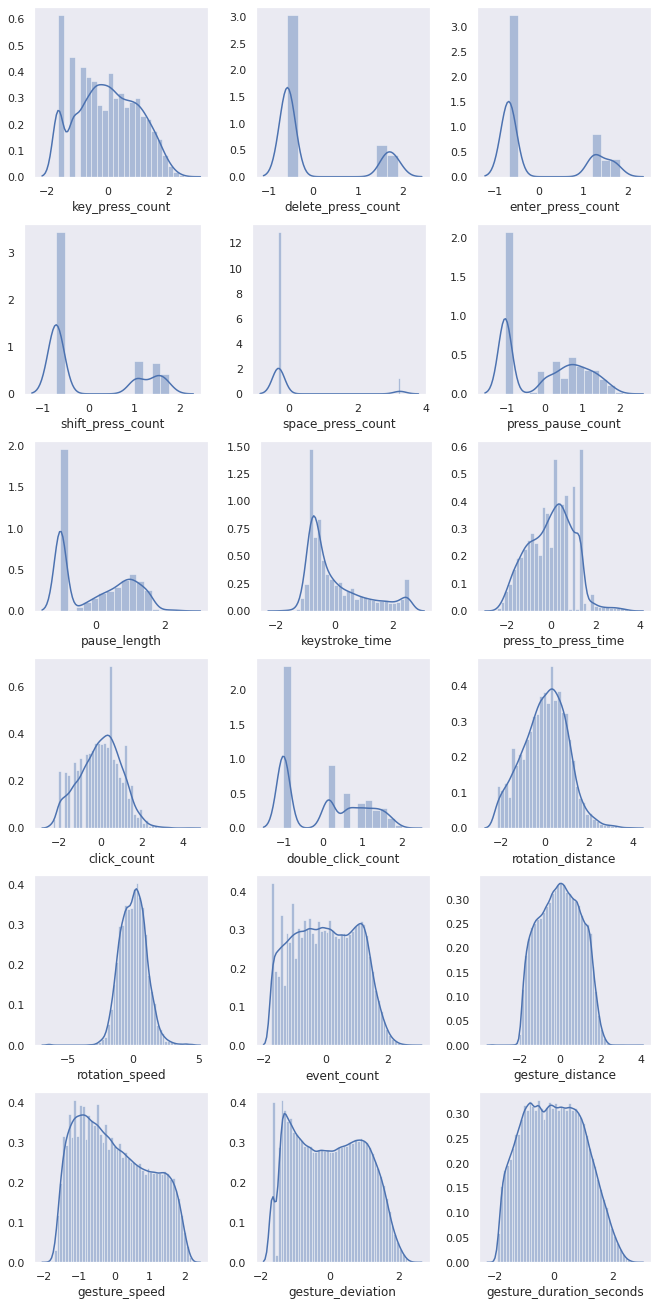

In [17]:
plot_distributions(data_normalized)

In [18]:
data_normalized

,key_press_count,delete_press_count,enter_press_count,shift_press_count,space_press_count,press_pause_count,pause_length,keystroke_time,press_to_press_time,click_count,double_click_count,rotation_distance,rotation_speed,event_count,gesture_distance,gesture_speed,gesture_deviation,gesture_duration_seconds
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.235000,-1.018732,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.451569,0.603764,1.935608,0.153703,-1.328687
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.016491,-0.250922,-0.311937,-0.543013,-0.374707
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.095768,0.368745,0.821665,-0.160400,-0.374707
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.230636,-0.418763,0.324898,-0.664834,-1.162586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.709703,-1.018732,NaN,NaN,NaN,NaN,NaN,NaN,NaN
234189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.135430,1.709427,1.835702,1.235915,0.851231
234190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.062349,-1.018732,NaN,NaN,NaN,NaN,NaN,NaN,NaN
234191,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.587424,-1.001799,-0.931318,0.038803,-0.909870


In [21]:
data_normalized.index = data.index

In [22]:
data_normalized

,key_press_count,delete_press_count,enter_press_count,shift_press_count,space_press_count,press_pause_count,pause_length,keystroke_time,press_to_press_time,click_count,double_click_count,rotation_distance,rotation_speed,event_count,gesture_distance,gesture_speed,gesture_deviation,gesture_duration_seconds
timestamp,,,,,,,,,,,,,,,,,,
2020-02-10 12:13:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.235000,-1.018732,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-10 12:13:15.372,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.451569,0.603764,1.935608,0.153703,-1.328687
2020-02-10 12:13:18.852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.016491,-0.250922,-0.311937,-0.543013,-0.374707
2020-02-10 12:13:20.332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.095768,0.368745,0.821665,-0.160400,-0.374707
2020-02-10 12:13:20.972,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.230636,-0.418763,0.324898,-0.664834,-1.162586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-26 12:02:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.709703,-1.018732,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-26 12:02:55.542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.135430,1.709427,1.835702,1.235915,0.851231
2020-03-26 12:03:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.062349,-1.018732,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
import numpy as np

In [28]:
data_normalized.columns

Index(['key_press_count', 'delete_press_count', 'enter_press_count',
       'shift_press_count', 'space_press_count', 'press_pause_count',
       'pause_length', 'keystroke_time', 'press_to_press_time', 'click_count',
       'double_click_count', 'rotation_distance', 'rotation_speed',
       'event_count', 'gesture_distance', 'gesture_speed', 'gesture_deviation',
       'gesture_duration_seconds'],
      dtype='object')

In [55]:
data_resampled=data_normalized.resample("15Min").apply([np.mean, np.std])

In [56]:
data_subset = data_resampled[data_resampled.columns[0:18]]

In [57]:
data_subset

key_press_count           delete_press_count            \
                               mean       std               mean       std   
timestamp                                                                    
2020-02-10 12:00:00             NaN       NaN                NaN       NaN   
2020-02-10 12:15:00             NaN       NaN                NaN       NaN   
2020-02-10 12:30:00             NaN       NaN                NaN       NaN   
2020-02-10 12:45:00             NaN       NaN                NaN       NaN   
2020-02-10 13:00:00             NaN       NaN                NaN       NaN   
...                             ...       ...                ...       ...   
2020-03-26 11:00:00        0.075188  1.207873          -0.578011  0.000000   
2020-03-26 11:15:00        0.851425  0.777019          -0.578011  0.000000   
2020-03-26 11:30:00        0.855763  1.146270           0.054010  1.079381   
2020-03-26 11:45:00             NaN       NaN                NaN       NaN   
2020-03-26 12:00:00             NaN       NaN                NaN       NaN   

                    enter_press_count           shift_press_count            \
                                 mean       std              mean       std   
timestamp                                                                     
2020-02-10 12:00:00               NaN       NaN               NaN       NaN   
2020-02-10 12:15:00               NaN       NaN               NaN       NaN   
2020-02-10 12:30:00               NaN       NaN               NaN       NaN   
2020-02-10 12:45:00               NaN       NaN               NaN       NaN   
2020-02-10 13:00:00               NaN       NaN               NaN       NaN   
...                               ...       ...               ...       ...   
2020-03-26 11:00:00         -0.689817  0.000000          0.266225  1.056833   
2020-03-26 11:15:00         -0.560936  0.499154          0.848575  0.988015   
2020-03-26 11:30:00          0.877333  1.089627          0.276051  1.236932   
2020-03-26 11:45:00               NaN       NaN               NaN       NaN   
2020-03-26 12:00:00               NaN       NaN               NaN       NaN   

                    space_press_count           press_pause_count       \
                                 mean       std              mean  std   
timestamp                                                                
2020-02-10 12:00:00               NaN       NaN               NaN  NaN   
2020-02-10 12:15:00               NaN       NaN               NaN  NaN   
2020-02-10 12:30:00               NaN       NaN               NaN  NaN   
2020-02-10 12:45:00               NaN       NaN               NaN  NaN   
2020-02-10 13:00:00               NaN       NaN               NaN  NaN   
...                               ...       ...               ...  ...   
2020-03-26 11:00:00         -0.309350  0.000000         -1.052788  0.0   
2020-03-26 11:15:00         -0.309350  0.000000         -1.052788  0.0   
2020-03-26 11:30:00          1.209423  1.894243         -1.052788  0.0   
2020-03-26 11:45:00               NaN       NaN               NaN  NaN   
2020-03-26 12:00:00               NaN       NaN               NaN  NaN   

                    pause_length      keystroke_time            \
                            mean  std           mean       std   
timestamp                                                        
2020-02-10 12:00:00          NaN  NaN            NaN       NaN   
2020-02-10 12:15:00          NaN  NaN            NaN       NaN   
2020-02-10 12:30:00          NaN  NaN            NaN       NaN   
2020-02-10 12:45:00          NaN  NaN            NaN       NaN   
2020-02-10 13:00:00          NaN  NaN            NaN       NaN   
...                          ...  ...            ...       ...   
2020-03-26 11:00:00    -1.034205  0.0      -0.181276  0.885110   
2020-03-26 11:15:00    -1.034205  0.0      -0.188404  0.336559   
2020-03-26 11:30:00    -1.034205  0.0      -0.802302  0.2

In [81]:
st = QuantileTransformer(output_distribution="normal")
st.fit(data_subset)

QuantileTransformer(copy=True, ignore_implicit_zeros=False, n_quantiles=1000,
                    output_distribution='normal', random_state=None,
                    subsample=100000)

In [82]:
data_subset_normalized = st.transform(data_subset)
data_subset_normalized = pd.DataFrame(data_subset_normalized, columns=data_subset.columns)

In [83]:
data_subset_normalized

key_press_count           delete_press_count           enter_press_count  \
                mean       std               mean       std              mean   
0                NaN       NaN                NaN       NaN               NaN   
1                NaN       NaN                NaN       NaN               NaN   
2                NaN       NaN                NaN       NaN               NaN   
3                NaN       NaN                NaN       NaN               NaN   
4                NaN       NaN                NaN       NaN               NaN   
...              ...       ...                ...       ...               ...   
4316        0.296128  1.199131          -5.199338 -5.199338         -5.199338   
4317        1.583703 -0.216013          -5.199338 -5.199338         -0.702315   
4318        1.597748  1.044459           0.292676  0.352151          1.148876   
4319             NaN       NaN                NaN       NaN               NaN   
4320             NaN       NaN                NaN       NaN               NaN   

               shift_press_count           space_press_count            \
           std              mean       std              mean       std   
0          NaN               NaN       NaN               NaN       NaN   
1          NaN               NaN       NaN               NaN       NaN   
2          NaN               NaN       NaN               NaN       NaN   
3          NaN               NaN       NaN               NaN       NaN   
4          NaN               NaN       NaN               NaN       NaN   
...        ...               ...       ...               ...       ...   
4316 -5.199338          0.502407  0.680215         -5.199338 -5.199338   
4317 -0.739737          1.296724  0.268180         -5.199338 -5.199338   
4318  0.758364          0.514060  1.756601          1.664063  1.738719   
4319       NaN               NaN       NaN               NaN       NaN   
4320       NaN               NaN       NaN               NaN       NaN   

     press_pause_count           pause_length           keystroke_time  \
                  mean       std         mean       std           mean   
0                  NaN       NaN          NaN       NaN            NaN   
1                  NaN       NaN          NaN       NaN            NaN   
2                  NaN       NaN          NaN       NaN            NaN   
3                  NaN       NaN          NaN       NaN            NaN   
4                  NaN       NaN          NaN       NaN            NaN   
...                ...       ...          ...       ...            ...   
4316         -5.199338 -5.199338    -5.199338 -5.199338      -0.137405   
4317         -5.199338 -5.199338    -5.199338 -5.199338      -0.142938   
4318         -5.199338 -5.199338    -5.199338 -5.199338      -1.725202   
4319               NaN       NaN          NaN       NaN            NaN   
4320               NaN       NaN          NaN       NaN            NaN   

               press_to_press_time           
           std                mean      std  
0          NaN                 NaN      NaN  
1          NaN                 NaN      NaN  
2          NaN                 NaN      NaN  
3          NaN                 NaN      NaN  
4          NaN                 NaN      NaN  
...        ...                 ...      ...  
4316  0.149842           -0.473756  0.89306  
4317 -0.945652           -1.630667 -0.27294  
4318 -1.273378           -1.637866  0.89976  
4319       NaN                 NaN      NaN  
4320       NaN                 NaN      NaN  

[4321 rows x 18 columns]

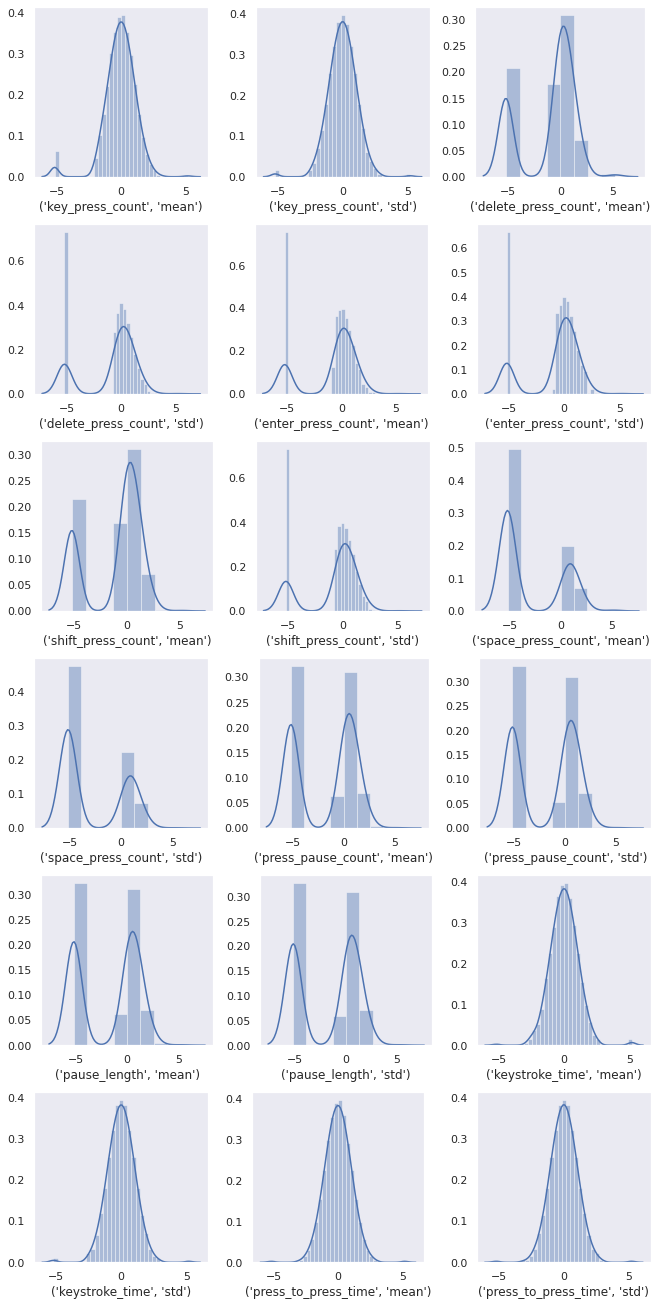

In [84]:
plot_distributions(data_subset_normalized)

In [ ]:
# Rolling window apply

In [157]:
def add_column_postfix(df: pd.DataFrame, postfix: str) -> pd.DataFrame:
    columns = df.columns
    mapping = {c: f"{c}_{postfix}" for c in columns}
    return df.rename(columns=mapping)

In [181]:
data_rolling_count = add_column_postfix(data_normalized.rolling('15Min', min_periods=1, win_type=None).count(), "count").resample("1Min").ffill()

In [182]:
data_rolling_sum = add_column_postfix(data_normalized.rolling('15Min', min_periods=1, win_type=None).sum(), "sum").resample("1Min").ffill()

In [183]:
data_rolling_mean = add_column_postfix(data_normalized.rolling('15Min', min_periods=1, win_type=None).mean(), "mean").resample("1Min").ffill()

In [184]:
data_rolling_median = add_column_postfix(data_normalized.rolling('15Min', min_periods=1, win_type=None).median(), "median").resample("1Min").ffill()

In [185]:
data_rolling_var = add_column_postfix(data_normalized.rolling('15Min', min_periods=1, win_type=None).var(), "var").resample("1Min").ffill()

In [186]:
data_rolling_kurt = add_column_postfix(data_normalized.rolling('15Min', min_periods=1, win_type=None).kurt(), "kurt").resample("1Min").ffill()

In [187]:
data_rolling_skew = add_column_postfix(data_normalized.rolling('15Min', min_periods=1, win_type=None).skew(), "skew").resample("1Min").ffill()

In [188]:
data_rolling = pd.concat([data_rolling_count, data_rolling_sum, data_rolling_mean, data_rolling_median, data_rolling_var, data_rolling_kurt, data_rolling_skew], axis=1)

In [189]:
data_rolling

,key_press_count_count,delete_press_count_count,enter_press_count_count,shift_press_count_count,space_press_count_count,press_pause_count_count,pause_length_count,keystroke_time_count,press_to_press_time_count,click_count_count,...,press_to_press_time_skew,click_count_skew,double_click_count_skew,rotation_distance_skew,rotation_speed_skew,event_count_skew,gesture_distance_skew,gesture_speed_skew,gesture_deviation_skew,gesture_duration_seconds_skew
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-02-10 12:13:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-10 12:14:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,0.113522,-1.384251,0.568562,0.291617,0.511355
2020-02-10 12:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,...,NaN,-1.732051,1.732051,NaN,NaN,-0.369285,-0.615757,0.829430,0.622644,0.092964
2020-02-10 12:16:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,-0.889037,2.000000,NaN,NaN,-0.272651,-0.480838,0.968055,0.751619,0.128085
2020-02-10 12:17:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,...,NaN,-0.598415,2.236068,NaN,NaN,-0.198359,-0.559129,0.886900,0.705495,0.114300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-26 11:59:00,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,...,0.891099,0.639435,-1.544444,-0.299305,-0.237669,0.237940,-0.009895,0.320267,0.181990,0.206823
2020-03-26 12:00:00,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,...,0.891099,0.639435,-1.544444,-0.299305,-0.237669,0.237940,-0.009895,0.320267,0.181990,0.206823
2020-03-26 12:01:00,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,...,0.891099,0.639435,-1.544444,-0.299305,-0.237669,0.237940,-0.009895,0.320267,0.181990,0.206823


In [190]:
data_rolling.dropna()

,key_press_count_count,delete_press_count_count,enter_press_count_count,shift_press_count_count,space_press_count_count,press_pause_count_count,pause_length_count,keystroke_time_count,press_to_press_time_count,click_count_count,...,press_to_press_time_skew,click_count_skew,double_click_count_skew,rotation_distance_skew,rotation_speed_skew,event_count_skew,gesture_distance_skew,gesture_speed_skew,gesture_deviation_skew,gesture_duration_seconds_skew
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-02-18 15:52:00,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,6.0,...,0.507238,1.303568,0.231521,-0.142492,-0.324308,-0.380768,-0.138063,0.049935,-0.232436,0.099081
2020-02-18 15:53:00,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,7.0,...,0.711045,1.312981,0.344434,1.233862,-0.221854,-0.294481,-0.043704,0.139383,-0.115138,0.157803
2020-02-18 15:54:00,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,8.0,...,0.191158,1.516894,0.296122,1.402094,-0.482972,-0.169137,0.073434,0.240282,0.030382,0.240133
2020-02-18 15:55:00,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,9.0,...,0.191158,1.166426,-0.003392,1.204648,-0.390186,-0.168180,0.063537,0.240739,0.058697,0.240284
2020-02-18 15:56:00,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,10.0,...,0.191158,1.329540,-0.196614,1.215495,-0.115907,-0.169697,0.091400,0.265163,0.086708,0.233494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-24 15:50:00,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,13.0,...,-0.013191,-1.043501,0.197790,-0.800269,1.042388,0.137521,-0.087059,0.579076,0.017680,0.057262
2020-03-24 15:51:00,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,13.0,...,0.316885,-0.737678,0.125756,-0.628181,0.860880,0.139325,-0.079833,0.592504,-0.025247,0.032978
2020-03-24 15:52:00,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,13.0,...,0.316885,-0.737678,0.125756,-0.628181,0.860880,0.092865,-0.135789,0.565655,-0.040995,0.030536


In [191]:
st_rolling = QuantileTransformer(output_distribution="normal")
st_rolling.fit(data_rolling)

QuantileTransformer(copy=True, ignore_implicit_zeros=False, n_quantiles=1000,
                    output_distribution='normal', random_state=None,
                    subsample=100000)

In [242]:
data_rolling_normalized = pd.DataFrame(st_rolling.transform(data_rolling), columns=data_rolling.columns, index=data_rolling.index)

In [218]:
timestamp_index = data_rolling.dropna().index

In [219]:
len(timestamp_index)

2086

In [ ]:
# PCA

In [244]:
pca_rolling = PCA()

In [246]:
pca_rolling.fit(data_rolling_normalized.fillna(0))

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [268]:
pca_rolling.explained_variance_

array([5.56002086e+01, 5.28528589e+01, 3.78308500e+01, 2.33256702e+01,
       1.73824121e+01, 1.23541964e+01, 9.72097365e+00, 7.86481281e+00,
       7.17811778e+00, 5.03358040e+00, 4.55951756e+00, 3.89325557e+00,
       3.40301322e+00, 3.10336802e+00, 2.49987246e+00, 2.19411016e+00,
       1.98781949e+00, 1.90076077e+00, 1.72959830e+00, 1.43588974e+00,
       1.41562477e+00, 1.27536819e+00, 1.22028266e+00, 1.03688079e+00,
       9.44747383e-01, 8.87490950e-01, 8.46416735e-01, 7.28465334e-01,
       6.50324731e-01, 6.23294202e-01, 5.67356864e-01, 5.46292335e-01,
       4.65419257e-01, 4.46376604e-01, 4.17032221e-01, 3.84313275e-01,
       3.66117961e-01, 3.36216921e-01, 3.03631116e-01, 2.63312628e-01,
       2.57930090e-01, 2.54575755e-01, 2.36007017e-01, 2.22915990e-01,
       2.16359587e-01, 2.06908040e-01, 1.91467321e-01, 1.83891802e-01,
       1.76909365e-01, 1.66609298e-01, 1.60423589e-01, 1.52126445e-01,
       1.47046896e-01, 1.30958342e-01, 1.27645176e-01, 1.23003441e-01,
      

In [270]:
pca_rolling.mean_

array([-3.78060728e-01, -3.78060728e-01, -3.78060728e-01, -3.78060728e-01,
       -3.78060728e-01, -3.78060728e-01, -3.78060728e-01, -3.78060728e-01,
       -3.78060728e-01, -4.40151877e-01, -4.40151877e-01, -4.21433212e-01,
       -4.21433212e-01, -9.12945796e-03, -9.12945796e-03, -9.12945796e-03,
       -9.12945796e-03, -9.12945796e-03, -2.60594420e-03, -4.69459743e-03,
       -7.43423869e-04, -2.66424429e-02, -2.43188128e-02, -4.25281949e-02,
       -2.24791953e-02, -4.55522291e-03, -1.86109758e-03, -2.46030961e-02,
       -3.22866631e-02, -2.99053621e-02, -1.26010870e-02, -1.06152380e-02,
       -7.37562064e-03, -2.44545921e-02, -2.15778443e-02, -3.19245559e-02,
       -5.05115032e-02, -1.06200987e+00, -1.32384250e+00, -1.20472182e+00,
       -2.86840394e+00, -1.56787961e+00, -1.57004191e+00, -7.12339135e-03,
       -1.11900268e-02, -2.35335748e-02, -8.41601544e-01, -2.17612424e-02,
       -1.61922374e-02, -7.53886995e-02, -2.04374248e-02, -4.11560810e-02,
       -2.35515825e-02, -

In [248]:
np.cumsum(pca_rolling.explained_variance_ratio_)[0:25]

array([0.20229314, 0.39459046, 0.53223242, 0.61709942, 0.68034276,
       0.72529167, 0.76066   , 0.78927496, 0.81539148, 0.83370542,
       0.85029455, 0.86445958, 0.87684095, 0.88813209, 0.89722751,
       0.90521045, 0.91244284, 0.91935848, 0.92565137, 0.93087564,
       0.93602618, 0.94066642, 0.94510624, 0.94887877, 0.9523161 ])

In [271]:
variance = np.cumsum(pca_rolling.explained_variance_ratio_)

In [274]:
variance[variance <= 0.95].shape[0]

24

In [250]:
# Keep the 25 most dominant axes
data_pca_dominant = pca_rolling.transform(data_rolling_normalized.fillna(0))[:, :25]

In [251]:
data_pca_dominant.shape

(64791, 25)

In [ ]:
# Clustering

In [252]:
from sklearn.cluster import KMeans

In [253]:
kmeans = KMeans(n_clusters=5)

In [254]:
# cluster data
cluster = kmeans.fit_predict(data_pca_dominant)

In [255]:
cluster

array([4, 4, 4, ..., 2, 4, 4], dtype=int32)

In [259]:
# add clustering as column to the original data frame
data_rolling['cluster'] = cluster

In [260]:
data_rolling

,key_press_count_count,delete_press_count_count,enter_press_count_count,shift_press_count_count,space_press_count_count,press_pause_count_count,pause_length_count,keystroke_time_count,press_to_press_time_count,click_count_count,...,click_count_skew,double_click_count_skew,rotation_distance_skew,rotation_speed_skew,event_count_skew,gesture_distance_skew,gesture_speed_skew,gesture_deviation_skew,gesture_duration_seconds_skew,cluster
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-02-10 12:13:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
2020-02-10 12:14:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,0.113522,-1.384251,0.568562,0.291617,0.511355,4
2020-02-10 12:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,...,-1.732051,1.732051,NaN,NaN,-0.369285,-0.615757,0.829430,0.622644,0.092964,4
2020-02-10 12:16:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,-0.889037,2.000000,NaN,NaN,-0.272651,-0.480838,0.968055,0.751619,0.128085,4
2020-02-10 12:17:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,...,-0.598415,2.236068,NaN,NaN,-0.198359,-0.559129,0.886900,0.705495,0.114300,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-26 11:59:00,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,...,0.639435,-1.544444,-0.299305,-0.237669,0.237940,-0.009895,0.320267,0.181990,0.206823,2
2020-03-26 12:00:00,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,...,0.639435,-1.544444,-0.299305,-0.237669,0.237940,-0.009895,0.320267,0.181990,0.206823,2
2020-03-26 12:01:00,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,...,0.639435,-1.544444,-0.299305,-0.237669,0.237940,-0.009895,0.320267,0.181990,0.206823,2


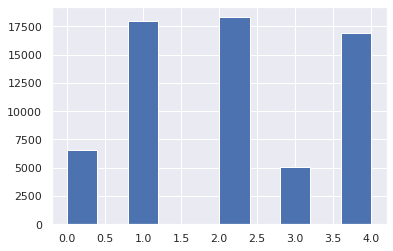

In [262]:
data_rolling.cluster.hist()

In [265]:
kmeans.cluster_centers_

array([[ 1.40115239e+01, -1.24673682e+01,  9.05067325e-01,
        -3.04959591e+00,  1.31732358e+00,  6.29011826e-01,
         6.42343932e-01, -1.55254362e+00,  6.88963710e-02,
         2.04601566e-01,  9.04483479e-01,  5.30300447e-01,
        -4.95419087e-01,  7.68371853e-01, -5.65961171e-01,
        -1.48439082e-01,  2.40995434e-01,  2.44497338e-01,
         2.59710039e-02,  4.42352101e-02, -1.24057867e-01,
        -8.36348779e-02, -6.19242386e-02, -1.71388701e-01,
         2.84929951e-01],
       [-4.27566586e+00,  8.24753343e-01, -6.37173835e+00,
        -3.85028017e+00, -4.04252813e-01, -2.57796251e-01,
         4.62759515e-01, -3.27231801e-01, -8.21380271e-01,
         1.86733318e-02,  1.69787132e-01, -1.36760154e-01,
         1.90419151e-01,  1.83223402e-01,  2.19488765e-01,
         1.95569722e-01,  2.90082362e-02, -6.48802335e-02,
        -8.46981391e-02,  1.16463263e-01,  6.64170639e-02,
        -8.76824035e-02,  1.87157618e-02,  2.36596388e-01,
        -6.98264426e-02],
    

In [241]:
data_rolling.fillna(0)

,key_press_count_count,delete_press_count_count,enter_press_count_count,shift_press_count_count,space_press_count_count,press_pause_count_count,pause_length_count,keystroke_time_count,press_to_press_time_count,click_count_count,...,press_to_press_time_skew,click_count_skew,double_click_count_skew,rotation_distance_skew,rotation_speed_skew,event_count_skew,gesture_distance_skew,gesture_speed_skew,gesture_deviation_skew,gesture_duration_seconds_skew
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-02-10 12:13:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-02-10 12:14:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.113522,-1.384251,0.568562,0.291617,0.511355
2020-02-10 12:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.000000,-1.732051,1.732051,0.000000,0.000000,-0.369285,-0.615757,0.829430,0.622644,0.092964
2020-02-10 12:16:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.000000,-0.889037,2.000000,0.000000,0.000000,-0.272651,-0.480838,0.968055,0.751619,0.128085
2020-02-10 12:17:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.000000,-0.598415,2.236068,0.000000,0.000000,-0.198359,-0.559129,0.886900,0.705495,0.114300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-26 11:59:00,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,...,0.891099,0.639435,-1.544444,-0.299305,-0.237669,0.237940,-0.009895,0.320267,0.181990,0.206823
2020-03-26 12:00:00,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,...,0.891099,0.639435,-1.544444,-0.299305,-0.237669,0.237940,-0.009895,0.320267,0.181990,0.206823
2020-03-26 12:01:00,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,...,0.891099,0.639435,-1.544444,-0.299305,-0.237669,0.237940,-0.009895,0.320267,0.181990,0.206823


In [86]:
import numpy as np
from sklearn.decomposition import PCA
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
PCA(n_components=2)
>>> print(pca.explained_variance_ratio_)
[0.9924... 0.0075...]
>>> print(pca.singular_values_)
[6.30061... 0.54980...]


In [87]:
pca.explained_variance_ratio_

array([0.99244289, 0.00755711])

In [88]:
pca.singular_values_

array([6.30061232, 0.54980396])

In [89]:
pca = PCA()

In [92]:
data_subset_normalized.dropna()

key_press_count           delete_press_count           enter_press_count  \
                mean       std               mean       std              mean   
781         1.414851 -0.714252          -5.199338 -5.199338          2.542349   
783        -0.086712 -0.184334           0.395552  0.737509         -0.349953   
786        -1.831224 -1.579968          -5.199338 -5.199338          0.065284   
787         5.199338 -2.207093          -5.199338 -5.199338          1.659093   
788         1.038563  0.434096          -0.104318 -0.191865          0.389783   
...              ...       ...                ...       ...               ...   
4314        0.837309  0.419593          -5.199338 -5.199338         -0.364191   
4315        1.955217 -1.459931          -5.199338 -5.199338          0.312444   
4316        0.296128  1.199131          -5.199338 -5.199338         -5.199338   
4317        1.583703 -0.216013          -5.199338 -5.199338         -0.702315   
4318        1.597748  1.044459           0.292676  0.352151          1.148876   

               shift_press_count           space_press_count            \
           std              mean       std              mean       std   
781  -0.803958         -5.199338 -5.199338         -5.199338 -5.199338   
783  -0.105780         -0.396560 -0.465405          0.795322  0.830234   
786   0.895780         -5.199338 -5.199338         -5.199338 -5.199338   
787  -5.199338          5.199338 -0.737282          1.371657  2.053336   
788   0.440383          0.492128  0.973369          0.621099  0.567211   
...        ...               ...       ...               ...       ...   
4314 -0.266584          1.177997 -0.197579          0.458426  0.388430   
4315  0.930099          1.107511  0.495723         -5.199338 -5.199338   
4316 -5.199338          0.502407  0.680215         -5.199338 -5.199338   
4317 -0.739737          1.296724  0.268180         -5.199338 -5.199338   
4318  0.758364          0.514060  1.756601          1.664063  1.738719   

     press_pause_count           pause_length           keystroke_time  \
                  mean       std         mean       std           mean   
781           1.739132  0.268639    -0.015312  0.466902      -0.828465   
783          -0.190221  0.392093    -0.187359  2.198388       0.301715   
786          -5.199338 -5.199338    -5.199338 -5.199338       1.340626   
787          -5.199338 -5.199338    -5.199338 -5.199338       0.303242   
788          -5.199338 -5.199338    -5.199338 -5.199338      -0.151818   
...                ...       ...          ...       ...            ...   
4314         -5.199338 -5.199338    -5.199338 -5.199338       0.730869   
4315         -5.199338 -5.199338    -5.199338 -5.199338      -0.324490   
4316         -5.199338 -5.199338    -5.199338 -5.199338      -0.137405   
4317         -5.199338 -5.199338    -5.199338 -5.199338      -0.142938   
4318         -5.199338 -5.199338    -5.199338 -5.199338      -1.725202   

               press_to_press_time            
           std                mean       std  
781  -2.511791           -1.425070 -0.456550  
783   0.735827            0.465375  0.414911  
786   2.317559            1.705602  0.219134  
787  -0.951228           -5.199338 -2.115096  
788  -0.087471           -1.066496  0.424802  
...        ...                 ...       ...  
4314  0.088930           -0.905198  0.326165  
4315 -0.977681           -1.908088 -1.283868  
4316  0.149842           -0.473756  0.893060  
4317 -0.945652           -1.630667 -0.272940  
4318 -1.273378           -1.637866  0.899760  

[582 rows x 18 columns]

In [93]:
pca.fit(data_subset_normalized.dropna())

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [94]:
pca.explained_variance_ratio_

array([0.36486963, 0.24649062, 0.12550351, 0.11128521, 0.07919525,
       0.02165189, 0.01600622, 0.01115119, 0.00604547, 0.00350958,
       0.00317851, 0.00259101, 0.00230295, 0.00198154, 0.0015803 ,
       0.00112805, 0.00110838, 0.00042071])

In [99]:
pca.transform(data_subset_normalized.dropna())

array([[ 5.52937958,  4.65095981,  5.37753854, ..., -0.13559362,
         0.22178808,  0.12981412],
       [ 4.00684117, -4.91742495, -1.09215219, ..., -0.63430249,
         0.62921671, -0.32265476],
       [-6.11208541,  6.40603182,  5.47669186, ...,  0.25697697,
        -0.26396456,  0.40112668],
       ...,
       [-6.01580799,  3.82658276,  6.10077863, ...,  0.05444283,
         0.10851179,  0.04004792],
       [-5.76070445,  1.85015597,  4.4910466 , ..., -0.28083892,
         0.10306479, -0.02053419],
       [-7.34086864, -7.16788554, -1.04570384, ..., -0.15082407,
         0.1208067 ,  0.06856678]])

In [1]:
from app import mpl_test_plot

In [24]:
def mpl_test_plot(device=None):
    if not device:
        device = ""
    import seaborn as sns
    from matplotlib.figure import Figure
    sns.set(style="whitegrid", palette="pastel", color_codes=True)

    fig = Figure(constrained_layout=True)
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title(device)
    # Load the example tips dataset
    tips = sns.load_dataset("tips")

    # Draw a nested violinplot and split the violins for easier comparison
    sns.violinplot(x="day", y="total_bill", hue="smoker",
                   split=True, inner="quart",
                   palette={"Yes": "y", "No": "b"},
                   data=tips, ax=ax)
    sns.despine(left=True)
    
    return fig

In [25]:
fig = mpl_test_plot()

<Figure size 432x288 with 0 Axes>

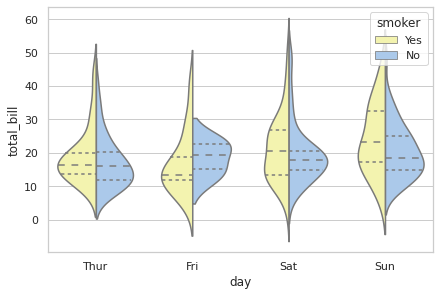

In [26]:
fig

In [27]:
fig.savefig?